<a href="https://colab.research.google.com/github/Seji-jam/Generic-Object-Oriented-Plant-Model/blob/main/Initial_Sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# constant
Activation_Energy_VCMAX = 65330  # Energy of activation for VCMAX (J/mol)
Activation_Energy_Jmax = 43790  # Energy of activation for Jmax (J/mol)
Entropy_Term_JT_Equation = 650  # Entropy term in JT equation (J/mol/K)
Deactivation_Energy_Jmax = 200000  # Energy of deactivation for Jmax (J/mol)
Maximum_Electron_Transport_Efficiency = 0.85  # Maximum electron transport efficiency of PS II
Protons_For_ATP_Synthesis = 3  # Number of protons required to synthesize 1 ATP
O2_Concentration = 210  # Oxygen concentration (mmol/mol)
Scattering_Coefficient_PAR = 0.2  # Leaf scattering coefficient for PAR
Scattering_Coefficient_NIR = 0.8  # Leaf scattering coefficient for NIR
Canopy_Diffuse_Reflection_Coefficient_PAR = 0.057  # Canopy diffuse PAR reflection coefficient
Canopy_Diffuse_Reflection_Coefficient_NIR = 0.389  # Canopy diffuse NIR reflection coefficient
wgauss = np.array([0.1184635, 0.2393144, 0.2844444, 0.2393144, 0.1184635])

# variable inputs
Ambient_CO2 = 400 #(ppm)
Fraction_AboveGround_Carbon=0.65
SLA_Const=0.16
Leaf_Blade_Angle = 45
Activation_Energy_JMAX=48041.88 #(J/mol)
VCMAX=85 #([µmol CO₂ m⁻² s⁻¹])
JMAX=170 #([µmol CO₂ m⁻² s⁻¹])
Photosynthetic_Light_Response_Factor=0.7
BTemp_Phen = 12.0  # Base temperature for phenological development (C)
#OTemp_Phen = 30.0  # Optimum temperature (C)
#CTemp_Phen = 40.0  # Critical temperature (C)
#TempCurve_Res = 0.5  # Temperature response curve factor
# the weather info
#Weather_File = 'https://raw.githubusercontent.com/Seji-jam/Generic-Object-Oriented-Plant-Model/main/v3-0-OOP-operational/Maricopa_WW.xlsx'
Weather_File = 'https://raw.githubusercontent.com/Seji-jam/Generic-Object-Oriented-Plant-Model/main/v3-0-OOP-operational/Synthetic_Mean.xlsx'


In [ ]:


class WeatherMeteo:
    def __init__(self, filename, lat, Simulation_Start_DOY):
        self.filename = filename
        self.lat = lat
        self.Sun_Angle_Inclination = -2
        self.Start_Time = Simulation_Start_DOY
        self.rad = np.pi / 180

    def meteo_calculations(self, doy):
        if not -67 <= self.lat <= 67:
            raise ValueError('ERROR IN meteo_calculations: LAT out of bounds [-67, 67]')

        dec = np.arcsin(np.sin(23.45 * self.rad) * np.cos(2 * np.pi * (doy + 10) / 365))
        Sin_Solar_Declination = np.sin(self.rad * self.lat) * np.sin(dec)
        Cos_Solar_Declination = np.cos(self.rad * self.lat) * np.cos(dec)
        angle_factor = Sin_Solar_Declination / Cos_Solar_Declination

        Day_Length = 12.0 * (1 + 2 * np.arcsin(angle_factor) / np.pi)
        Photoperiod_Day_Length = 12.0 * (1 + 2 * np.arcsin((-np.sin(self.Sun_Angle_Inclination * self.rad) + Sin_Solar_Declination) / Cos_Solar_Declination) / np.pi)
        Daily_Sin_Beam_Exposure = 3600 * (Day_Length * (Sin_Solar_Declination + 0.4 * (Sin_Solar_Declination**2 + Cos_Solar_Declination**2 * 0.5)) +
                         12.0 * Cos_Solar_Declination * (2.0 + 3.0 * 0.4 * Sin_Solar_Declination) * np.sqrt(1.0 - angle_factor**2) / np.pi)
        Solar_Constant = 1367 * (1 + 0.033 * np.cos(2 * np.pi * (doy - 10) / 365))

        return Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination, Day_Length, Photoperiod_Day_Length, Daily_Sin_Beam_Exposure

    def process_data(self):
        nld = pd.read_excel(self.filename, sheet_name='Sheet1').values
        data_results = []

        for i, row in enumerate(nld):
            Station, Year, Doy, Solar_Radiation, Min_Temp, Max_Temp, Vapour_Pressure, Wind_Speed, Rain = row
            Solar_Radiation *= 1000  # Convert from kj m-2 day-1 to j m-2 day-1
            time = Doy

            dfs = time - self.Start_Time + 1

            Wind_Speed = max(0.1, Wind_Speed)

            Day_time_Temp = 0.29 * Min_Temp + 0.71 * Max_Temp
            Night_Time_Temp = 0.71 * Min_Temp + 0.29 * Max_Temp



            Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination, Day_Length, Photoperiod_Day_Length, Daily_Sin_Beam_Exposure=self.meteo_calculations(Doy)


            # Store the calculated values in a dictionary
            iteration_results = {
                'Station': Station, 'Year': Year, 'Doy': Doy,'dfs':dfs,
                'Max_Temp': Max_Temp, 'Min_Temp': Min_Temp, 'Solar_Radiation': Solar_Radiation,'Rain':Rain, 'Vapour_Pressure': Vapour_Pressure,
                'Wind_Speed': Wind_Speed, 'Day_time_Temp': Day_time_Temp, 'Night_Time_Temp': Night_Time_Temp,
                # Add meteorological calculations
                'Solar_Constant': Solar_Constant, 'Sin_Solar_Declination':Sin_Solar_Declination,'Cos_Solar_Declination':Cos_Solar_Declination,'Day_Length':Day_Length,
                'Photoperiod_Day_Length':Photoperiod_Day_Length,'Daily_Sin_Beam_Exposure':Daily_Sin_Beam_Exposure
            }

            data_results.append(iteration_results)

        return data_results

    def convert_daily_to_hourly(Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination, Day_Length,
                                Daily_Sin_Beam_Exposure, Solar_Radiation, Max_Temp, Min_Temp, Wind,
                                Vapour_Pressure,Ambient_CO2):

         Gaussian_Points = 5
         x_Gauss = np.array([0.0469101, 0.2307534, 0.5000000, 0.7692465, 0.9530899])
         # w_Gauss = np.array([0.1184635, 0.2393144, 0.2844444, 0.2393144, 0.1184635])

         Instantaneous_data = []
         for i in range(Gaussian_Points):
             hour = 12 - 0.5 * Day_Length + Day_Length * x_Gauss[i]
             Solar_Elevation_Sin = max(0., Sin_Solar_Declination + Cos_Solar_Declination * np.cos(2. * np.pi * (hour - 12.) / 24.))
             Instantaneous_radiation = Solar_Radiation * (Solar_Elevation_Sin * Solar_Constant/1367) / Daily_Sin_Beam_Exposure
             Instantaneous_Temp = Min_Temp + (Max_Temp - Min_Temp) * np.sin(np.pi * (hour + Day_Length / 2 - 12) / (Day_Length + 3))
             Instantaneous_data.append((Solar_Constant, Instantaneous_Temp, Solar_Elevation_Sin, Instantaneous_radiation, Wind,Vapour_Pressure,Ambient_CO2))

         return Instantaneous_data

In [ ]:
class Plant:
    def __init__(self, environment, resource_pools):
        self.environment = environment
        self.current_thermal_time = 0.0
        #self.previous_thermal_time = 0.0
        self.assimilated_carbon = 0.0
        self.resource_pools = resource_pools
        self.allocation_log = []
        self.Leaf_Area_Index=0.005
        self.Daily_Thermal_Unit = 0.0
        self.assimilations_Licor = 0.0
        self.Daily_PAR_Sunlit=0
        self.Daily_PAR_Shaded=0
        self.Sunlit_Fr=0



    def photosynthesis(self, Absorbed_PAR, Leaf_Temp, Intercellular_CO2, Photosynthetic_Light_Response_Factor,
                       Activation_Energy_Jmax, VCMAX,JMAX):

        """
        Calculate the net photosynthesis rate of a C3 plant canopy. From ref: [ADD REFERENCE HERE]
        Parameters:
        - Absorbed_PAR: Photosynthetically Active Radiation absorbed by the canopy, per unit ground area [W m⁻²]
        - Leaf_Temp: Canopy temperature [°C]
        - Intercellular_CO2: Intercellular CO2 concentration [μmol mol-1]
        - VCMAX : Canopy maximum carboxylation rate at 25 C, per unit ground area # [µmol m⁻² s⁻¹]
        - JMAX : Canopy maximum electron transport rate at 25 C, per unit ground area # [µmol m⁻² s⁻¹]
        - Photosynthetic_Light_Response_Factor: Dimensionless parameter for the light response curve
        Returns:
        - Net_Photosynthesis: Net photosynthesis rate of canopy, per unit ground area [g CO₂ m⁻² s⁻¹]
        """


        # Temperature adjustment factors
        temp_factor = 1. / 298. - 1. / (Leaf_Temp + 273.) # calculate factor for how canopy temp [converted to Kelvin] deviates from reference temp (298 K)
        Carboxylation_Temperature_Effect = math.exp(temp_factor * Activation_Energy_VCMAX / 8.314)
        Electron_Transport_Temperature_Effect = (math.exp(temp_factor * Activation_Energy_Jmax / 8.314) *
            (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - Deactivation_Energy_Jmax / 298. / 8.314)) /
            (1. + math.exp(Entropy_Term_JT_Equation / 8.314 - 1. / (Leaf_Temp + 273.) * Deactivation_Energy_Jmax / 8.314)))

        # Adjusted VCMAX and JMAX based on temperature
        Adjusted_VCMAX = VCMAX * Carboxylation_Temperature_Effect
        Adjusted_JMAX =  JMAX * Electron_Transport_Temperature_Effect

        # Conversion of absorbed PAR to photon flux density
        Photon_Flux_Density = 4.56 * Absorbed_PAR  # 1 W/m2 ≈ 4.6 [µmol m⁻² s⁻¹] --> Conversion factor
        # refer to : https://www.controlledenvironments.org/wp-content/uploads/sites/6/2017/06/Ch01.pdf

        # Michaelis-Menten constants adjusted for temperature
        KMC = 404.9 * math.exp(temp_factor * 79430 / 8.314)
        KMO = 278.4 * math.exp(temp_factor * 36380 / 8.314)

        # CO2 compensation point without dark respiration
        CO2_Compensation_No_Respiration = 0.5 * math.exp(-3.3801 + 5220. / (Leaf_Temp + 273.) / 8.314) * O2_Concentration * KMC / KMO

        # Electron transport rate in response to absorbed PAR photon flux
        Quantum_Efficiency_Adjustment = (1 - 0) / (1 + (1 - 0) / Maximum_Electron_Transport_Efficiency)
        Electron_Transport_Ratio = Quantum_Efficiency_Adjustment * Photon_Flux_Density / max(1E-10, Adjusted_JMAX)
        Adjusted_Electron_Transport_Rate = Adjusted_JMAX * (1 + Electron_Transport_Ratio - ((1 + Electron_Transport_Ratio)**2 - 4 * Electron_Transport_Ratio * Photosynthetic_Light_Response_Factor)**0.5) / 2 / Photosynthetic_Light_Response_Factor

        # Carboxylation rates limited by Rubisco activity and electron transport
        Carboxylation_Rate_Rubisco_Limited = Adjusted_VCMAX * Intercellular_CO2 / (Intercellular_CO2 + KMC * (O2_Concentration / KMO + 1.))
        Carboxylation_Rate_Electron_Transport_Limited = Adjusted_Electron_Transport_Rate * Intercellular_CO2 * (2 + 0 - 0) / Protons_For_ATP_Synthesis / (0 + 3 * Intercellular_CO2 + 7 * CO2_Compensation_No_Respiration) / (1 - 0)

        # Gross rate of canopy photosynthesis
        Gross_Photosynthesis = (1 - CO2_Compensation_No_Respiration / Intercellular_CO2) * min(Carboxylation_Rate_Rubisco_Limited, Carboxylation_Rate_Electron_Transport_Limited)
        Gross_Photosynthesis = max(1E-10, (1E-6) * 44 * Gross_Photosynthesis) # Converts µmol CO₂ m⁻² s⁻¹ to g CO₂ m⁻² s⁻¹

        # Net photosynthesis
        Net_Photosynthesis = Gross_Photosynthesis

        return Net_Photosynthesis # [g CO₂ m⁻² ground area s⁻¹]


    def KDR_Coeff(self,Solar_Elev_Sin, Leaf_Blade_Angle):

        # Convert solar elevation sine to angle in radians
        Solar_Elev_Angle = np.arcsin(Solar_Elev_Sin)

        # Calculate average projection of leaves in the direction of solar beam
        if Solar_Elev_Sin >= np.sin(Leaf_Blade_Angle):
            Leaf_Orientation_Avg = Solar_Elev_Sin * np.cos(Leaf_Blade_Angle)
        else:
            Leaf_Orientation_Avg = (2 / np.pi) * (Solar_Elev_Sin * np.cos(Leaf_Blade_Angle) * np.arcsin(np.tan(Solar_Elev_Angle) / np.tan(Leaf_Blade_Angle)) + ((np.sin(Leaf_Blade_Angle))**2 - Solar_Elev_Sin**2)**0.5)

        # Calculate beam radiation extinction coefficient
        Direct_Beam_Ext_Coeff = Leaf_Orientation_Avg / Solar_Elev_Sin

        return Direct_Beam_Ext_Coeff


    def KDF_Coeff(self, Leaf_Area_Index, Leaf_Blade_Angle, Scattering_Coeff):

        # Extinction coefficients for direct light at 15, 45, and 75 degrees elevation
        Beam_Ext_Coeff_15 = self.KDR_Coeff(np.sin(15. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_45 = self.KDR_Coeff(np.sin(45. * np.pi / 180.), Leaf_Blade_Angle)
        Beam_Ext_Coeff_75 = self.KDR_Coeff(np.sin(75. * np.pi / 180.), Leaf_Blade_Angle)

        # Calculate diffuse light extinction coefficient
        Diffuse_Ext_Coeff = -1 / self.Leaf_Area_Index * np.log(0.178 * np.exp(-Beam_Ext_Coeff_15 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index) +
                            0.514 * np.exp(-Beam_Ext_Coeff_45 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index) +
                            0.308 * np.exp(-Beam_Ext_Coeff_75 * (1.0 - Scattering_Coeff)**0.5 * self.Leaf_Area_Index))

        return Diffuse_Ext_Coeff


    def REFLECTION_Coeff(self,Leaf_Scattering_Coeff, Direct_Beam_Ext_Coeff):
        """
        Calculates reflection coefficients for beam radiation.
        Parameters:
        - Leaf_Scattering_Coeff: Leaf scattering coefficient.
        - Direct_Beam_Ext_Coeff: Direct beam radiation extinction coefficient.
        Returns:
        - Scattered_Beam_Ext_Coeff: Scattered beam radiation extinction coefficient.
        - Canopy_Beam_Reflect_Coeff: Canopy beam radiation reflection coefficient.
        """
        # Scattered beam radiation extinction coefficient calculation
        Scattered_Beam_Ext_Coeff = Direct_Beam_Ext_Coeff * (1 - Leaf_Scattering_Coeff)**0.5

        # Canopy reflection coefficient for horizontal leaves calculation
        Horizontal_Leaf_Phase_Function = (1 - (1 - Leaf_Scattering_Coeff)**0.5) / (1 + (1 - Leaf_Scattering_Coeff)**0.5)

        # Canopy beam radiation reflection coefficient calculation
        Canopy_Beam_Reflect_Coeff = 1 - np.exp(-2 * Horizontal_Leaf_Phase_Function * Direct_Beam_Ext_Coeff / (1 + Direct_Beam_Ext_Coeff))

        return Scattered_Beam_Ext_Coeff, Canopy_Beam_Reflect_Coeff


    def INTERNAL_CO2(self,Leaf_Temp, VPD, VPD_Slope, Ambient_CO2):

        # Air-to-Leaf vapor pressure deficit
        Saturated_Vapor_Pressure_Leaf = 0.611 * np.exp(17.4 * Leaf_Temp / (Leaf_Temp + 239.))
        Vapor_Pressure_Deficit_Leaf = max(0, Saturated_Vapor_Pressure_Leaf - VPD)

        # Constants based on crop type
        Michaelis_Menten_CO2_25C =  404.9
        Michaelis_Menten_O2_25C =  278.4

        # Adjustment for temperature
        KMC = Michaelis_Menten_CO2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 79430 / 8.314)
        KMO = Michaelis_Menten_O2_25C * np.exp((1./298. - 1./(Leaf_Temp + 273.)) * 36380 / 8.314)

        Dark_Respiration_VCMAX_Ratio_25C=0.0089   #input_constant

        # CO2 compensation point without dark respiration
        CO2_compensation_point_no_resp = 0.5 * np.exp(-3.3801 + 5220./(Leaf_Temp + 273.) / 8.314) * 210 * KMC / KMO
        dark_respiration_Vcmax_ratio  = Dark_Respiration_VCMAX_Ratio_25C * np.exp((1/298 - 1/(Leaf_Temp + 273)) * (46390 - 65330) / 8.314)
        CO2_compensation_point_conditional =(CO2_compensation_point_no_resp + dark_respiration_Vcmax_ratio * KMC * (1 + 210 / KMO)) / (1 - dark_respiration_Vcmax_ratio)
        CO2_compensation_point =   CO2_compensation_point_conditional

        Intercellular_CO2_Ratio = 1 - (1 - CO2_compensation_point / Ambient_CO2) * (0.14 + VPD_Slope * Vapor_Pressure_Deficit_Leaf)

        # Intercellular CO2 concentration
        Intercellular_CO2 = Intercellular_CO2_Ratio * Ambient_CO2

        return Saturated_Vapor_Pressure_Leaf, Intercellular_CO2


    def LIGHT_ABSORB(self,Scattering_Coeff, Direct_Beam_Ext_Coeff, Scattered_Beam_Ext_Coeff, Diffuse_Ext_Coeff, Canopy_Beam_Reflect_Coeff, Canopy_Diffuse_Reflect_Coeff, Direct_PAR, Diffuse_PAR, Leaf_Area_Index):

        Total_Canopy_Absorbed_Light = (1. - Canopy_Beam_Reflect_Coeff) * Direct_PAR * (1. - np.exp(-Scattered_Beam_Ext_Coeff * self.Leaf_Area_Index)) + (1. - Canopy_Diffuse_Reflect_Coeff) * Diffuse_PAR * (1. - np.exp(-Diffuse_Ext_Coeff * self.Leaf_Area_Index))

        Absorbed_Sunlit_Rad = (1 - Scattering_Coeff) * Direct_PAR * (1 - np.exp(-Direct_Beam_Ext_Coeff * self.Leaf_Area_Index)) \
            + (1 - Canopy_Diffuse_Reflect_Coeff) * Diffuse_PAR / (Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * Diffuse_Ext_Coeff * (1 - np.exp(-(Diffuse_Ext_Coeff + Direct_Beam_Ext_Coeff) * self.Leaf_Area_Index)) \
            + Direct_PAR * ((1 - Canopy_Beam_Reflect_Coeff) / (Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * Scattered_Beam_Ext_Coeff * (1 - np.exp(-(Scattered_Beam_Ext_Coeff + Direct_Beam_Ext_Coeff) * self.Leaf_Area_Index)) \
                                          - (1 - Scattering_Coeff) * (1 - np.exp(-2 * Direct_Beam_Ext_Coeff * self.Leaf_Area_Index)) / 2)

        Absorbed_Shaded_Rad = Total_Canopy_Absorbed_Light - Absorbed_Sunlit_Rad

        return Absorbed_Sunlit_Rad, Absorbed_Shaded_Rad


    def calculate_thermal_units(self,Tmax, Tmin, BTemp_Phen):
        Tmean = (Tmax + Tmin) / 2
        degree_day = max(0, Tmean - BTemp_Phen)
        self.Daily_Thermal_Unit = degree_day
        return degree_day


    def calculate_carbon_assimilates( self,Scattering_Coefficient_PAR,
                                     Canopy_Diffuse_Reflection_Coefficient_PAR ,
                                     Activation_Energy_Jmax,Vcmax,Jmax,
                                     Photosynthetic_Light_Response_Factor,
                                     Leaf_Blade_Angle,
                                     Hourly_data,Day_Length
                                     ) :



        Canopy_Instant_Photosynthesys_rate_List=[]
        Absorbed_PAR_Shaded_list=[]
        Absorbed_PAR_Sunlit_list=[]
        Sunlit_Fr_list=[]
        Instant_Photosynthesis_Rate_licor_list=[]

        for Solar_Constant, Hourly_Temp, Sin_Beam, Hourly_Solar_Radiation, Wind_Speed, Vapour_Pressure,Ambient_CO2 in Hourly_data:
            # Use sunlit Leaf temperature if it differs from ambient

            #ASSUMPTION
            Sunlit_Leaf_Temp=Hourly_Temp
            Shaded_Leaf_Temp=Hourly_Temp



            Incoming_PAR = 0.5 * Hourly_Solar_Radiation
            Atmospheric_Transmissivity = Incoming_PAR / (0.5 * Solar_Constant * Sin_Beam)

            # Calculate diffuse light fraction
            if Atmospheric_Transmissivity < 0.22:
                Diffuse_Light_Fraction = 1
            elif 0.22 < Atmospheric_Transmissivity <= 0.35:
                Diffuse_Light_Fraction = 1 - 6.4 * (Atmospheric_Transmissivity - 0.22) ** 2
            else:
                Diffuse_Light_Fraction = 1.47 - 1.66 * Atmospheric_Transmissivity

            Diffuse_Light_Fraction = max(Diffuse_Light_Fraction, 0.15 + 0.85 * (1 - np.exp(-0.1 / Sin_Beam)))

            Diffuse_PAR = Incoming_PAR * Diffuse_Light_Fraction
            Direct_PAR = Incoming_PAR - Diffuse_PAR

            Leaf_Blade_Angle_Radians = Leaf_Blade_Angle * np.pi / 180
            Direct_Beam_Extinction_Coefficient = self.KDR_Coeff(Sin_Beam, Leaf_Blade_Angle_Radians)

            ###
            Diffuse_Extinction_Coefficient_PAR = self.KDF_Coeff(self.Leaf_Area_Index, Leaf_Blade_Angle_Radians, Scattering_Coefficient_PAR)

            Scattered_Beam_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR = self.REFLECTION_Coeff(Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient)


            # Adjusting for vapor pressure deficit influence on intercellular CO2 concentration
            Vapor_Pressure_Deficit_Response = 0.195127  # Slope for linear effect of VPDL on Ci/Ca (VPDL: Air-to-Leaf vapour pressure deficit)
            Sat_Vapor_Pressure_Sunlit, Intercellular_CO2_Concentration_Sunlit = self.INTERNAL_CO2(Sunlit_Leaf_Temp, Vapour_Pressure, Vapor_Pressure_Deficit_Response, Ambient_CO2)
            Sat_Vapor_Pressure_Shaded, Intercellular_CO2_Concentration_Shaded = self.INTERNAL_CO2(Shaded_Leaf_Temp, Vapour_Pressure, Vapor_Pressure_Deficit_Response, Ambient_CO2)

            # Calculating photosynthetic nitrogen availability for sunlit canopy parts
            # Photosynthetic_Nitrogen_Sunlit = Specific_Leaf_N_Top * (1. - np.exp(-(Leaf_Nitro_Ext_Coeff + Direct_Beam_Extinction_Coefficient) * self.Leaf_Area_Index)) / (Leaf_Nitro_Ext_Coeff + Direct_Beam_Extinction_Coefficient) - Min_Specific_Leaf_N * (1. - np.exp(-Direct_Beam_Extinction_Coefficient * self.Leaf_Area_Index)) / Direct_Beam_Extinction_Coefficient

            # Absorption of PAR by sunlit leaves - reference: de Pury and Farquhar 1997 Plant Cell and Env. (SJ, pls double check this is correct ref)
            Absorbed_PAR_Sunlit, Absorbed_PAR_Shaded = self.LIGHT_ABSORB(Scattering_Coefficient_PAR, Direct_Beam_Extinction_Coefficient, Scattered_Beam_Extinction_Coefficient_PAR, Diffuse_Extinction_Coefficient_PAR, Canopy_Beam_Reflection_Coefficient_PAR, Canopy_Diffuse_Reflection_Coefficient_PAR, Direct_PAR, Diffuse_PAR, self.Leaf_Area_Index)

            Sunlit_Fraction = 1. / Direct_Beam_Extinction_Coefficient / self.Leaf_Area_Index * (1. - np.exp(-Direct_Beam_Extinction_Coefficient * self.Leaf_Area_Index))

            Absorbed_PAR_L_Sunlit=Absorbed_PAR_Sunlit/(self.Leaf_Area_Index*Sunlit_Fraction)
            Absorbed_PAR_L_Shaded=Absorbed_PAR_Shaded/(self.Leaf_Area_Index*(1-Sunlit_Fraction))


            Sunlit_Fr_list.append(Sunlit_Fraction)
            Absorbed_PAR_Shaded_list.append(Absorbed_PAR_L_Shaded)
            Absorbed_PAR_Sunlit_list.append(Absorbed_PAR_L_Sunlit)

            # Calculating potential photosynthesis for sunlit and shaded components of canopy
            Net_Photosynthesis_Sunlit = self.photosynthesis( Absorbed_PAR_Sunlit, Sunlit_Leaf_Temp, Intercellular_CO2_Concentration_Sunlit,
                                                       Photosynthetic_Light_Response_Factor, Activation_Energy_Jmax, Vcmax,Jmax)
            Net_Photosynthesis_Shaded = self.photosynthesis( Absorbed_PAR_Shaded, Shaded_Leaf_Temp, Intercellular_CO2_Concentration_Shaded,
                                                       Photosynthetic_Light_Response_Factor, Activation_Energy_Jmax, Vcmax,Jmax)

            # Get total photosynthesis
            Canopy_Instant_Photosynthesys_rate = Net_Photosynthesis_Sunlit* Sunlit_Fraction+  Net_Photosynthesis_Shaded *(1-Sunlit_Fraction) # [g C m⁻² ground area s⁻¹]
            Canopy_Instant_Photosynthesys_rate_List.append(Canopy_Instant_Photosynthesys_rate)
            Instant_Photosynthesis_Rate_licor_list.append(Net_Photosynthesis_Sunlit/ (Sunlit_Fraction*self.Leaf_Area_Index)) # converts to [g C m⁻² leaf area s⁻¹]

        weighted_data = np.array(Canopy_Instant_Photosynthesys_rate_List) * wgauss # [g C02 m⁻² s⁻¹]
        Daily_Potential_Canopy_Photosynthesis = weighted_data.sum() * Day_Length* 3600 # converts to [g C02 m⁻² ground area day⁻¹]
        self.assimilated_carbon=  12/44 * Daily_Potential_Canopy_Photosynthesis # converts to [g Carbon m⁻² ground area day⁻¹]

        self.assimilations_Licor  =  Instant_Photosynthesis_Rate_licor_list[1]*10**6 / (44) # gets the second segment of photosynthesis computed at five segments daily and converts to [µmol CO₂ m⁻² leaf area s⁻¹] to compare to LICOR6800 readings

        self.Daily_PAR_Sunlit=Absorbed_PAR_Sunlit_list[1] *4.56
        self.Daily_PAR_Shaded=Absorbed_PAR_Shaded_list[1] *4.56

        self.Sunlit_Fr=Sunlit_Fr_list


    def update_LAI(self):

        # get carbon from RP1 (consider it as "leaves" by default)
        leaf_carbon = self.resource_pools[0].current_size

        # Calculate updated LAI
        LAI_new = SLA_Const * leaf_carbon

        # Update LAI
        self.Leaf_Area_Index = LAI_new

    def allocate_carbon(self):

        #DeltaThermalTime = self.current_thermal_time - self.previous_thermal_time
        #self.previous_thermal_time = self.current_thermal_time  # Update previous thermal time

        # Update initiation status of resource pools
        for rp in self.resource_pools:
            rp.update_initiation_status(self.current_thermal_time)

        total_assimilated_carbon = self.assimilated_carbon
        active_rps = [rp for rp in self.resource_pools if rp.is_initiated]
        demands = {}
        total_demand = 0.0
        allocation_details = {}

        # Calculate demand for each active resource pool
        for rp in active_rps:
            #demand = rp.calculate_demand(self.current_thermal_time, DeltaThermalTime)
            demand = rp.calculate_demand(self.current_thermal_time, plant.Daily_Thermal_Unit)
            demands[rp] = demand
            total_demand += demand

        if total_demand <= 0:
            self.allocation_log.append({})
            return

        remaining_carbon = total_assimilated_carbon
        sorted_rps = sorted(active_rps, key=lambda x: x.allocation_priority)

        # Allocate carbon based on demand and priority
        for rp in sorted_rps:
            if demands[rp]>remaining_carbon:
                print('carbon limited')
            allocation = min(demands[rp], remaining_carbon)
            rp.receive_carbon(allocation)
            allocation_details[rp.name] = {'demand': demands[rp], 'allocation': allocation}
            remaining_carbon -= allocation
            if remaining_carbon <= 0.0:
                break

        self.allocation_log.append(allocation_details)
        self.update_LAI()




In [ ]:
class Environment:
    def __init__(self, weather_meteo, stress_factor=1.0):
        self.stress_factor = stress_factor
        self.weather_data = weather_meteo.process_data()  # Get processed weather data for all timesteps


In [ ]:
class ResourcePool:
    def __init__(self, name, initiation_thermal_time, allocation_priority, max_size, growth_rate, N0):
        """
        Initialize a Resource Pool.

        Parameters:
        - name (str): Name of the resource pool (e.g., 'leaves').
        - initiation_thermal_time (float): Thermal time at which the RP is initiated.
        - allocation_priority (int): Priority for carbon allocation (lower number --> higher priority).
        - max_size (float): Maximum size (K) of the RP.
        - growth_rate (float): Growth rate (r) of the RP.
        - N0 (float): Initial size at RP initiation time.
        """
        self.name = name
        self.initiation_thermal_time = initiation_thermal_time
        self.allocation_priority = allocation_priority
        self.max_size = max_size  # parameter K
        self.growth_rate = growth_rate  # parameter r
        self.N0 = N0
        self.demand=0
        self.rgr=0
        self.current_size = N0  # Initialize with parameter N0
        self.is_initiated = False

    def update_initiation_status(self, plant_thermal_time):
        if plant_thermal_time >= self.initiation_thermal_time:
            self.is_initiated = True

    def calc_RGR(self, RP_age, K, N0, r):
        """
        Calculate the relative growth rate (RGR) based on thermal age of the RP.
        RGR is computed as the logarithmic derivative of the three-parameter (K, N0, r) logistic growth curve

        Ref: RGR function from Wang et al., 2019 (Journal of Experimental Botany)

        Parameters:
        - RP_age (float): Thermal age of the RP.
        - K (float): Maximum size (K) of the RP.
        - N0 (float): Initial size at RP initiation time.
        - r (float): Growth rate (r) of the RP.

        Returns:
        - RGR (float): Relative growth rate

        """
        A = (K - N0) / N0
        exp_component = math.exp(-r * RP_age)
        f_prime = (K * A * r * exp_component) / (1 + A * exp_component) ** 2
        f = K / (1 + A * exp_component)
        RGR = f_prime / f

        #RGR = self.growth_rate * (1 - self.current_size / self.max_size)

        self.RGR = RGR

        return RGR

    def calculate_demand(self, plant_thermal_time, DeltaThermalTime):
        """
        Calculate carbon demand based on RGR and current size.

        Parameters:
        - plant_thermal_time (float): Current thermal time of the plant.

        Returns:
        - demand (float): Carbon demand for growth of RP.
        """

        RP_age = plant_thermal_time - self.initiation_thermal_time

        demand = 0

        if RP_age >0:
            RGR = self.calc_RGR(RP_age, self.max_size, self.N0, self.growth_rate)
            demand = RGR * self.current_size * DeltaThermalTime
            self.demand = demand

        return demand

    def receive_carbon(self, allocated_carbon):
        self.current_size += allocated_carbon



In [ ]:
def run_simulation(plant, environment, num_days):
    assimilated_carbon_log = []
    rp_allocations_log = {rp.name: [] for rp in plant.resource_pools}
    total_allocated_carbon_log = []
    lai_log=[]
    thermal_log=[]
    cumulative_thermal_log=[]
    assimilations_Licor_log=[]
    max_temp_log=[]
    min_temp_log=[]
    radiation_log=[]

    rgr_log = {rp.name: [] for rp in plant.resource_pools}
    current_size_log = {rp.name: [] for rp in plant.resource_pools}
    demand_log = {rp.name: [] for rp in plant.resource_pools}
    remaining_carbon_log = []
    Daily_PAR_Sunlit_Log=[]
    Daily_PAR_Shaded_Log=[]
    Sunlit_Fr_log=[]
    Sunlit_Fr_subdaily = []


    for day in range(num_days):
        day_data = environment.weather_data[day]
        Solar_Constant=day_data['Solar_Constant']
        Sin_Solar_Declination = day_data['Sin_Solar_Declination']
        Cos_Solar_Declination = day_data['Cos_Solar_Declination']
        Day_Length = day_data['Day_Length']
        Daily_Sin_Beam_Exposure = day_data['Daily_Sin_Beam_Exposure']
        Solar_Radiation = day_data['Solar_Radiation']
        max_temp = day_data['Max_Temp']
        min_temp = day_data['Min_Temp']
        Vapour_Pressure = day_data['Vapour_Pressure']
        Wind_Speed = day_data['Wind_Speed']
        # rain = day_data['Rain']
        doy=int(day_data['Doy'])

        #High_temp scenario
        # max_temp+=2
        # min_temp+=2

        # #low_temp scenario
        # max_temp-=2
        # min_temp-=2

        # #low_high_low temp scenario
        # if day < 75:
        #     max_temp-=3
        #     min_temp-=3
        # if (day > 75)&(day <85):
        #     max_temp+=3
        #     min_temp+=3
        # if day > 85:
        #     max_temp-=3
        #     min_temp-=3

        #high_low_high temp scenario
        # if day < 75:
        #     max_temp+=3
        #     min_temp+=3
        # if (day > 75)&(day <85):
        #     max_temp-=3
        #     min_temp-=3
        # if day > 85:
        #     max_temp+=3
        #     min_temp+=3


        # #High_Rad scenario
        # Solar_Radiation*=1.5

        # #low_Rad scenario
        # Solar_Radiation*=0.5

        max_temp_log.append(max_temp)
        min_temp_log.append(min_temp)
        radiation_log.append(Solar_Radiation)




        Hourly_data = WeatherMeteo.convert_daily_to_hourly(Solar_Constant, Sin_Solar_Declination, Cos_Solar_Declination,
                                                      Day_Length, Daily_Sin_Beam_Exposure, Solar_Radiation,
                                                      max_temp, min_temp, Wind_Speed,Vapour_Pressure,Ambient_CO2)






        # Calculate thermal units
        daily_thermal_units = plant.calculate_thermal_units(max_temp, min_temp,BTemp_Phen)

        # Update the plant's thermal time
        plant.current_thermal_time += daily_thermal_units

        cumulative_thermal_log.append(plant.current_thermal_time)
        # Perform photosynthesis and calculate assimilated carbon
        plant.calculate_carbon_assimilates(
            Scattering_Coefficient_PAR, Canopy_Diffuse_Reflection_Coefficient_PAR,
            Activation_Energy_Jmax, VCMAX, JMAX,
            Photosynthetic_Light_Response_Factor,
            Leaf_Blade_Angle, Hourly_data,Day_Length)

        # Allocate carbon to resource pools
        plant.allocate_carbon()



        # Log data for plotting
        Sunlit_Fr_log.append(plant.Sunlit_Fr)
        Daily_PAR_Sunlit_Log.append(plant.Daily_PAR_Sunlit)
        Daily_PAR_Shaded_Log.append(plant.Daily_PAR_Shaded)
        remaining_carbon = plant.assimilated_carbon
        remaining_carbon_log.append(remaining_carbon)
        lai_log.append(plant.Leaf_Area_Index)
        thermal_log.append([doy,daily_thermal_units])


        assimilations_Licor_log.append(plant.assimilations_Licor)
        assimilated_carbon_log.append(plant.assimilated_carbon)

        total_allocated_carbon = 0
        for rp in plant.resource_pools:
            if rp.is_initiated:
                total_allocated_carbon += rp.current_size
                rp_allocations_log[rp.name].append(rp.current_size)


                rgr_log[rp.name].append(rp.RGR)
                current_size_log[rp.name].append(rp.current_size)
                demand_log[rp.name].append(rp.demand)
            else:
                rp_allocations_log[rp.name].append(0)
                rgr_log[rp.name].append(0)
                current_size_log[rp.name].append(0)
                demand_log[rp.name].append(0)

        total_allocated_carbon_log.append(total_allocated_carbon)

    # Combine logs into a DataFrame and write to CSV
    results_df = pd.DataFrame({
        'Day': list(range(1, num_days + 1)),
        'Total Allocated Carbon': total_allocated_carbon_log,
        'LAI': lai_log,
        'Thermal Units': thermal_log,
        'Assimilations Licor': assimilations_Licor_log,
        'Max Temp': max_temp_log,
        'Min Temp': min_temp_log,
        'Radiation': radiation_log
    })
    for rp_name, allocations in rp_allocations_log.items():
        results_df[f'{rp_name} Allocation'] = allocations
    results_df.to_csv("simulation_results_base.csv", index=False)
    #files.download("simulation_results_base.csv")

    def plot_results():
      for day_fr in Sunlit_Fr_log:
          Sunlit_Fr_subdaily.extend(day_fr)  # Append subdaily values for each day
      sub_daily_time_steps = np.arange(len(Sunlit_Fr_subdaily))

      """
      plt.figure(figsize=(12, 6))
      plt.plot(sub_daily_time_steps, Sunlit_Fr_subdaily, marker='o', linestyle='-', color='purple', label='Sunlit Fraction (Subdaily)')
      plt.xlabel('Subdaily Time Steps')
      plt.ylabel('Sunlit Fraction')
      plt.title('Subdaily Variation of Sunlit Fraction Over Time')
      plt.legend()
      plt.grid(True)
      plt.xlim(395, 404)
      plt.show()

      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, Daily_PAR_Sunlit_Log, label='PAR Sunlit', color='orange', marker='D')
      plt.plot(cumulative_thermal_log, Daily_PAR_Shaded_Log, label='PAR Shaded', color='blue', marker='D')
      plt.xlabel('Degree Day')
      plt.ylabel('PAR')
      plt.legend()
      plt.grid(True)
      plt.show()



      plt.figure(figsize=(10, 6))
      plt.plot(lai_log,  [sublist[0] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 1', color='orange', marker='D')
      plt.plot(lai_log, [sublist[1] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 2', color='red', marker='D')
      plt.plot(lai_log, [sublist[2] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 3', color='black', marker='D')
      plt.plot(lai_log, [sublist[3] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 4', color='blue', marker='D')
      plt.plot(lai_log, [sublist[4] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 5', color='magenta', marker='D')
      plt.xlabel('LAI')
      plt.ylabel('Sunlit_Fr')
      plt.legend()
      plt.grid(True)
      plt.show()

      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log,  [sublist[0] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 1', color='orange', marker='D')
      plt.plot(cumulative_thermal_log, [sublist[1] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 2', color='red', marker='D')
      plt.plot(cumulative_thermal_log, [sublist[2] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 3', color='black', marker='D')
      plt.plot(cumulative_thermal_log, [sublist[3] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 4', color='blue', marker='D')
      plt.plot(cumulative_thermal_log, [sublist[4] for sublist in Sunlit_Fr_log], label='PAR Sunlit at Time 5', color='magenta', marker='D')
      plt.xlabel('Degree Day')
      plt.ylabel('Sunlit_Fr')
      plt.legend()
      plt.grid(True)
      plt.show()

      """

      plt.figure(figsize=(10, 6))
      for rp_name in rgr_log:
          plt.plot(cumulative_thermal_log, rgr_log[rp_name], label=f'RGR ({rp_name})')
      plt.xlabel('Thermal Time')
      plt.ylabel('Relative growth rate (RGR)')
      plt.legend()
      plt.grid(True)
      plt.show()

      """


      plt.figure(figsize=(10, 6))
      for rp_name in current_size_log:
          plt.plot(cumulative_thermal_log, current_size_log[rp_name], label=f'Current Size ({rp_name})')
      plt.xlabel('Thermal Time')
      plt.ylabel('Current Size')
      plt.legend()
      plt.grid(True)
      plt.show()

      """

      plt.figure(figsize=(10, 6))
      for rp_name in demand_log:
          plt.plot(cumulative_thermal_log, np.cumsum(demand_log[rp_name]), label=f'Demand ({rp_name})')
      plt.xlabel('Thermal Time')
      plt.ylabel('Demand')
      plt.legend()
      plt.grid(True)
      plt.show()

      """

      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, remaining_carbon_log, label='Remaining Carbon')
      plt.xlabel('Thermal Time')
      plt.ylabel('Remaining Carbon')
      plt.legend()
      plt.grid(True)
      plt.show()


      # Plot assimilated carbon
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, max_temp_log, label='Max Temp', color='red', marker='o')
      plt.plot(cumulative_thermal_log, min_temp_log, label='Min Temp', color='blue', marker='*')
      plt.title('Temp')
      plt.xlabel('Day')
      plt.ylabel('Max/Min temp (C)')
      plt.legend()
      plt.grid(True)
      plt.show()


      # Plot assimilated carbon
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, radiation_log, label='Solar Radiation', color='orange', marker='D')
      plt.title('Solar Radiation')
      plt.xlabel('Day')
      plt.ylabel('Solar Radiation')
      plt.legend()
      plt.grid(True)
      plt.show()
      """

      # Plot assimilated carbon
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, assimilated_carbon_log, label='Assimilated Carbon', color='blue', marker='o')
      plt.title('Daily Assimilated Carbon')
      plt.xlabel('Day')
      plt.ylabel('Carbon (g)')
      plt.legend()
      plt.grid(True)
      plt.show()

      # Plot assimilated carbon Licor
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, assimilations_Licor_log, label='Assimilated Carbon', color='blue', marker='o')
      plt.title('Assimilated Carbon licor')
      plt.xlabel('Day')
      plt.ylabel('Carbon (micromul/m2s1)')
      plt.legend()
      plt.grid(True)
      plt.show()



      # Plot LAI
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, lai_log, label='LAI (Leaf Area Index)', color='red', marker='^')  # <-- Plot LAI
      plt.xlabel('Thermal time (deg C day)', fontsize = 14)
      plt.ylabel('LAI', fontsize = 14)
      plt.legend()
      plt.grid(True)
      plt.show()


      # Plot allocated carbon for each resource pool
      color_map = {
          'RP1': 'blue',
          'RP2': 'green',
          'RP3': 'red',
          'RP4': 'orange',
          'RP5': 'purple',
          'RP6': 'brown',
          'RP7': 'pink',
      }


      plt.figure(figsize=(10, 6))
      for rp_name, allocations in rp_allocations_log.items():
          color = color_map.get(rp_name, 'black')
          plt.plot(cumulative_thermal_log, allocations, label=f'Allocated to {rp_name}', color = color, linestyle='--', marker='x')
      plt.xlabel('Thermal time (deg C day)', fontsize = 14)
      plt.ylabel('RP size (g)', fontsize = 14)
      plt.legend()
      plt.grid(True)
      plt.show()



      # Plot total allocated carbon
      plt.figure(figsize=(10, 6))
      plt.plot(cumulative_thermal_log, total_allocated_carbon_log, label='Total Allocated Carbon', color='green', marker='s', linestyle='-.')
      plt.title('Assimilated Carbon and Allocated Carbon to Resource Pools')
      plt.xlabel('Day')
      plt.ylabel('Carbon (g)')
      plt.legend()
      plt.grid(True)
      plt.show()
      # return(thermal_log)



    plot_results()

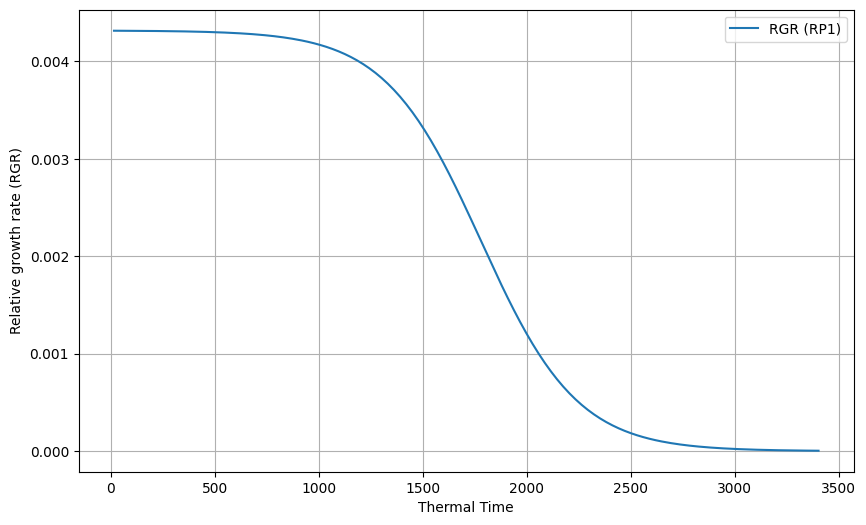

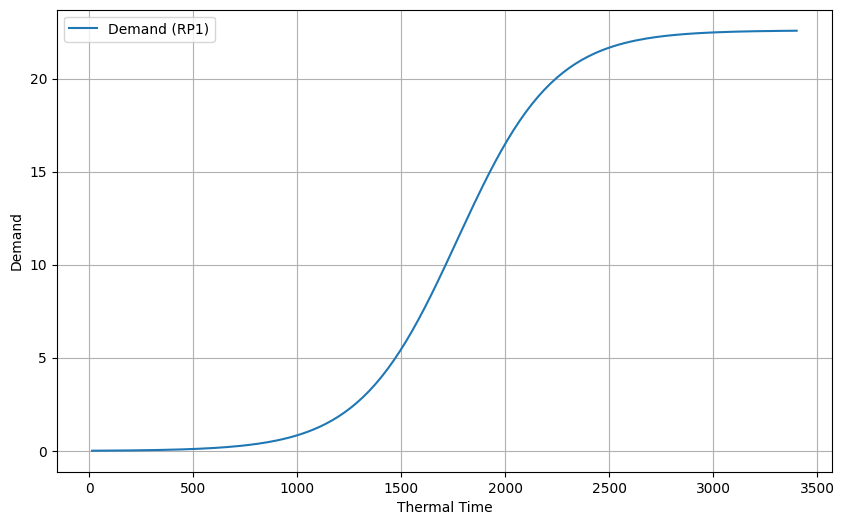

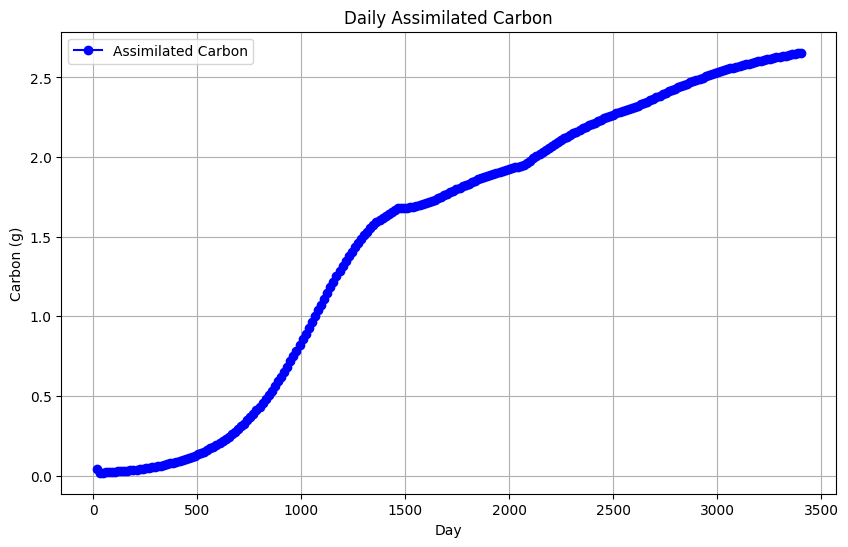

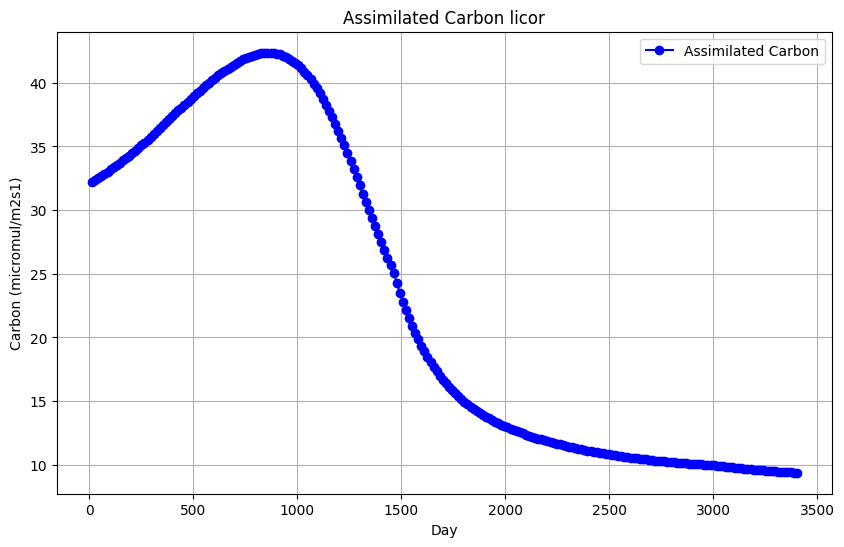

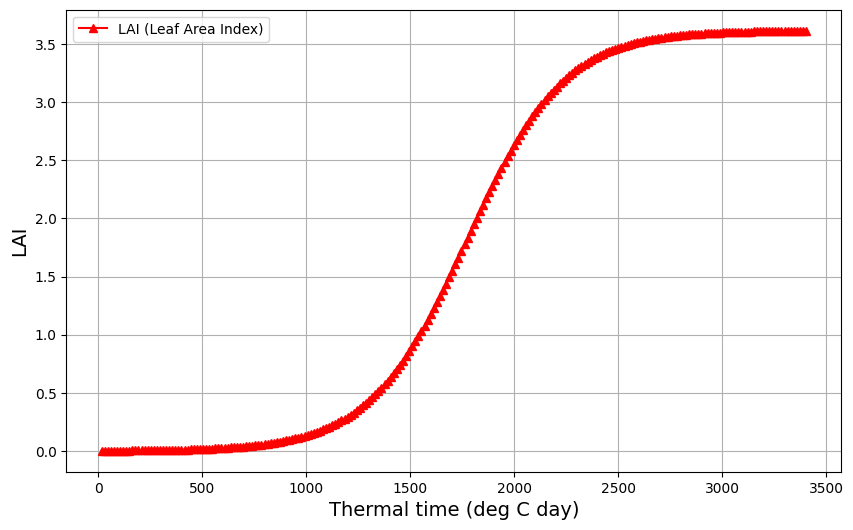

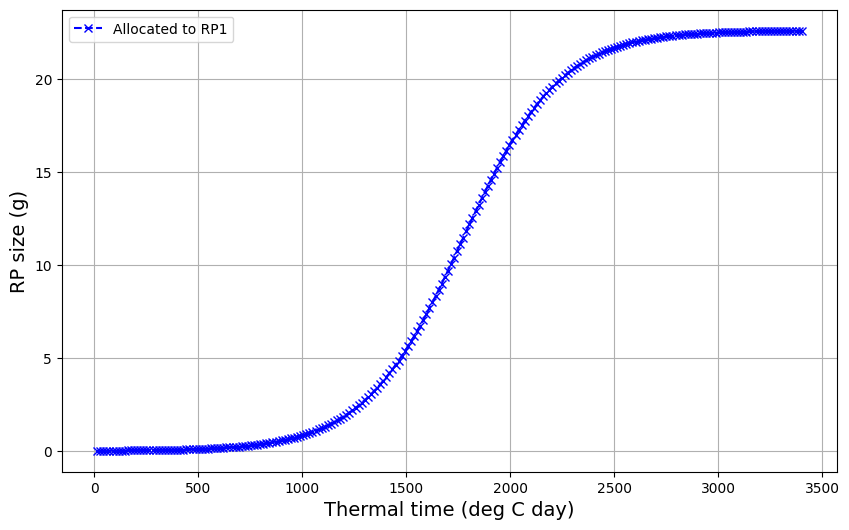

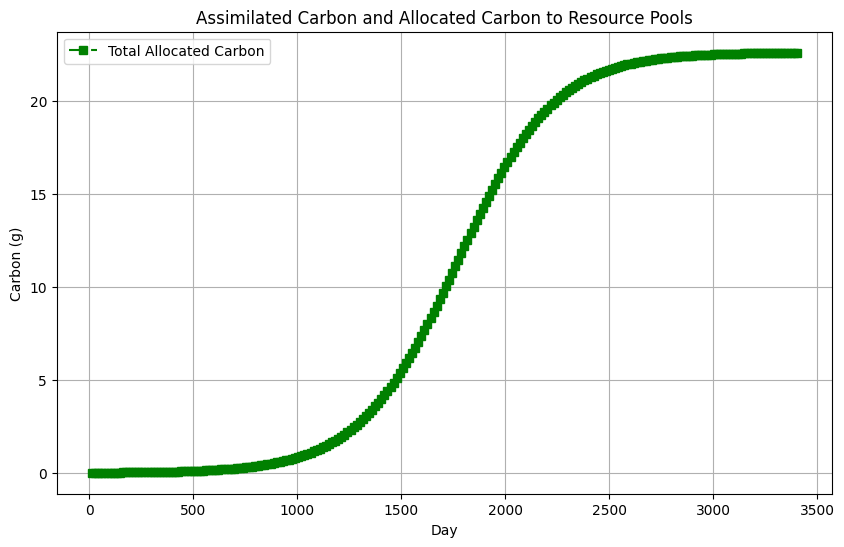

In [ ]:
# Example Run ...just to make sure everything is working :)
from google.colab import files

weather_meteo = WeatherMeteo(Weather_File, lat=30, Simulation_Start_DOY=1)
environment = Environment(weather_meteo)

# Define resource pools
resource_pools = [
    ResourcePool(
        name="RP1",
        initiation_thermal_time=10.0,
        allocation_priority=1,
        max_size= 27.42123018775174,
        N0 = 0.01321572378724811,
        growth_rate = 0.004317335636012717
    )
]

plant = Plant(environment, resource_pools)
run_simulation(plant, environment, num_days=230)

In [ ]:
#